### 分析报告说明


目标：
    现有一套闲置的房子想出租，需要个合适的定价；为了不再盲目相信物业推荐的价格，特用机器学习来推算个合适的价格；

房子信息：
    地址：湖里祥店新村1区，楼层 6/8, 楼中楼，面积约 180 平方， 4 室 2 厅 3 卫，南北朝向
    
训练的数据源来源：
    八爪鱼抓取 2017 年 10 月国庆期间厦门小鱼所有湖里地区的租房信息；
    
使用算法：
    1. XGBRegressor：
        推算定价准确度 90.28%
        最后推荐定价 5938.43 元 / 月
    2. GradientBoostingRegressor：
        推算定价准确度 90.26%
        最后推荐定价 5258.22 元 / 月
    3. RandomForestRegressor：
        推算定价准确度 89.35%
        最后推荐定价 6030.84 元 / 月
     
    平均定价 (5938.43 + 5258.22 + 6030.84) / 3 = 5742.50 元 / 月
    
    
广告： *** 现 9折 优惠 5200 元 / 月 ***
##### 5200元/月 180平方! 5200元/月 180平方! 5200元/月 180平方! 重要事情说三遍


感谢该博客的作者，房租价格是按该思路一步步推算出来 （博客地址： http://www.cnblogs.com/irenelin/p/7400388.html ）

======================================  分割线 =================================================

下面为推算过程

In [1]:
import sys
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
import warnings
from sklearn.preprocessing import LabelEncoder 
from scipy.special import boxcox1p

plt.rc('font', family='SimHei', size=13)

### 1. 观察数据

In [2]:
df = pd.read_csv('./h3.csv')
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 0 to 2394
Data columns (total 12 columns):
标题      1578 non-null object
价格      1578 non-null int64
出租类型    1578 non-null object
房屋类型    1578 non-null object
格局      1578 non-null object
面积      1578 non-null object
朝向      1578 non-null object
装修      1128 non-null object
楼层      1128 non-null object
小区      1578 non-null object
位置      1558 non-null object
发布人     1578 non-null object
dtypes: int64(1), object(11)
memory usage: 160.3+ KB


In [3]:
df.head()

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人
0,东方巴黎广场大阳台拎包入住随时看房单身公寓1700,1700,整租,普通住宅,1室1厅1卫,40平米,朝南北,中等装修,第3层/共8层,东方巴黎广场二期,SM附近,经纪人：
1,江头吕厝精装高层大3房看中庭2阳台仅4400,4400,整租,普通住宅,3室2厅2卫,122平米,朝南北,中等装修,第27层/共32层,冠宏花园,江头北路,经纪人：
2,台湾街江头公园旁江头小学居家清爽2房2100,2100,整租,普通住宅,2室1厅1卫,50平米,朝南北,中等装修,第8层/共23层,台湾街建邦大厦,台湾街,经纪人：
3,sm旁温馨2房独门独户独立厨卫新家具家电干净宽敞舒适,3000,整租,普通住宅,2室2厅1卫,80平米,朝南北,精装修,第7层/共30层,潇湘大厦,SM附近,经纪人：
4,精装修三房拎包入住高档富人社区海景房族7800邮轮城东渡,7800,整租,普通住宅,3室2厅2卫,136平米,朝南北,精装修,第9层/共30层,国际邮轮城一期,东渡,经纪人：


In [4]:
s = df.格局.unique()
s.sort()
s

array(['1室0厅0卫', '1室0厅1卫', '1室1厅0卫', '1室1厅1卫', '1室1厅2卫', '1室2厅1卫',
       '2室0厅1卫', '2室0厅2卫', '2室1厅0卫', '2室1厅1卫', '2室1厅2卫', '2室2厅1卫',
       '2室2厅2卫', '3室1厅1卫', '3室1厅2卫', '3室1厅3卫', '3室2厅1卫', '3室2厅2卫',
       '3室2厅3卫', '3室3厅2卫', '4室1厅1卫', '4室2厅1卫', '4室2厅2卫', '4室2厅3卫',
       '4室2厅4卫', '4室3厅0卫', '4室3厅3卫', '5室1厅3卫', '5室2厅0卫', '5室2厅1卫',
       '5室2厅2卫', '5室2厅3卫', '5室2厅4卫', '5室3厅4卫', '5室3厅6卫', '5室5厅5卫',
       '6室1厅2卫', '6室2厅1卫', '6室2厅2卫', '6室3厅4卫', '7室2厅2卫', '9室5厅9卫'], dtype=object)

In [5]:
df.朝向.unique()

array(['朝南北', '第14层/共14层', '第9层/共9层', '第13层/共15层', '第8层/共13层', '朝南', '朝北',
       '朝东', '朝西', '第5层/共11层', '第5层/共13层', '第6层/共13层', '第6层/共6层',
       '第8层/共14层', '朝西南', '第6层/共11层', '第10层/共14层', '第15层/共15层',
       '第11层/共13层', '朝东南', '第10层/共31层', '第8层/共11层', '第3层/共13层', '第4层/共7层',
       '第9层/共13层', '第3层/共14层', '朝东西', '第12层/共14层', '第2层/共8层', '第13层/共13层',
       '第5层/共14层', '第7层/共8层', '第6层/共14层', '第5层/共9层', '第3层/共6层', '第3层/共11层',
       '第16层/共29层', '第4层/共6层', '第2层/共13层', '第4层/共14层', '第7层/共13层',
       '第13层/共18层', '第9层/共14层', '第10层/共15层', '第26层/共35层', '第7层/共15层',
       '第8层/共8层', '第14层/共15层', '第4层/共5层', '第2层/共14层', '第4层/共11层',
       '第13层/共30层', '第18层/共35层', '第4层/共28层', '朝西北', '第2层/共5层', '第12层/共15层',
       '第7层/共14层', '第10层/共32层', '第24层/共32层', '第13层/共14层', '第14层/共28层',
       '第15层/共25层', '第11层/共14层', '第5层/共32层', '第3层/共5层', '第15层/共32层',
       '第10层/共13层', '第5层/共8层', '第11层/共15层', '朝东北', '第14层/共19层', '第5层/共5层',
       '第15层/共28层', '第1层/共14层', '第6层/共32层', '第16层/共19层', '第4层/共13层',
      

In [6]:
# df.loc[df.发布人 == '经纪人：', '发布人'] = '中介'
mask = df.朝向.str.contains('第*层')
# d.朝向.unique()
df.loc[mask, '楼层'] = df.loc[mask, '朝向']

df.loc[mask, '朝向'] = np.NaN

In [7]:
df.朝向.unique()

array(['朝南北', nan, '朝南', '朝北', '朝东', '朝西', '朝西南', '朝东南', '朝东西', '朝西北',
       '朝东北'], dtype=object)

In [8]:
s = df.楼层.unique()
s.sort()
s

array(['第10层/共11层', '第10层/共12层', '第10层/共13层', '第10层/共14层', '第10层/共15层',
       '第10层/共18层', '第10层/共19层', '第10层/共20层', '第10层/共24层', '第10层/共25层',
       '第10层/共26层', '第10层/共27层', '第10层/共28层', '第10层/共29层', '第10层/共30层',
       '第10层/共31层', '第10层/共32层', '第10层/共35层', '第10层/共39层', '第11层/共11层',
       '第11层/共12层', '第11层/共13层', '第11层/共14层', '第11层/共15层', '第11层/共17层',
       '第11层/共18层', '第11层/共19层', '第11层/共20层', '第11层/共21层', '第11层/共22层',
       '第11层/共24层', '第11层/共25层', '第11层/共27层', '第11层/共28层', '第11层/共30层',
       '第11层/共31层', '第11层/共32层', '第11层/共41层', '第12层/共12层', '第12层/共13层',
       '第12层/共14层', '第12层/共15层', '第12层/共16层', '第12层/共18层', '第12层/共19层',
       '第12层/共20层', '第12层/共21层', '第12层/共22层', '第12层/共24层', '第12层/共25层',
       '第12层/共26层', '第12层/共28层', '第12层/共30层', '第12层/共31层', '第12层/共32层',
       '第12层/共34层', '第12层/共35层', '第13层/共13层', '第13层/共14层', '第13层/共15层',
       '第13层/共16层', '第13层/共17层', '第13层/共18层', '第13层/共20层', '第13层/共21层',
       '第13层/共23层', '第13层/共24层', '第13层/共25层', '第13层/共26层', '第13层

In [9]:
df.describe()

,价格
count,1578.000000
mean,3405.506971
std,3495.465754
min,48.000000
25%,1650.000000
50%,2599.000000
75%,4000.000000
max,55000.000000


In [10]:
df.装修.unique()

array(['中等装修', '精装修', nan, '豪华装修', '简单装修', '毛坯'], dtype=object)

In [11]:
df.发布人.unique()

array(['经纪人：', '品牌公寓：',
       '个人                                                ：', '金山'], dtype=object)

In [12]:
df.小区.unique()

array(['东方巴黎广场二期', '冠宏花园', '台湾街建邦大厦', '潇湘大厦', '国际邮轮城一期', 'UONE天地',
       '国际石材中心', '华永天地', '佳馨美墅', '东方巴黎广场三期', '世茂湖滨首府', '新景园二期', '新景天湖广场',
       '明发豪庭', '福龙公寓', '源昌鑫海湾', '万达SOHO公寓', '建发中央天成', '金枋世家', '久邦公寓',
       '汇景新城中心', '大唐五缘YOHO', '中铁财富港湾', '湖里万达广场', '书香佳缘', '宏益华府', '力拓新城',
       '力拓大厦', '国际山庄四期', '特房五缘新座', '建发湾区SOHO', '特房山水尚座', '尚忠公寓', '中铺社',
       '龙门天下', '国宝新城', '豪峰大厦', '中港花园二期', '福隆国际', '永建顶尚', '水晶苹果', '古龙居住公园',
       '信诚VBO', '岭兜佳园', '湾区SOHO', '融景湾', '万科湖心岛', '安兜社', '科瑞大厦', '中环花园',
       '嘉盛花园江头', '泊寓（华昌店）', 'l力拓新城', '大洋雅苑', '裕兴大厦', '特房五缘尊府', '凯悦新城',
       '高新技术园', '泊寓高新店【限量特价精装LOFT大床房】', '枋湖花园', '中央湾区', '源昌宝墅湾', '东方巴黎广场',
       '世茂湖滨首府B区', '国际邮轮城二期', '银龙公寓', '万达广场', '联发新天地', '金尚风景（福满园）', '国贸阳光',
       '万科中心云玺', '宝龙御湖官邸', '万科中心', '国贸阳光一期', '亿星大厦', '高林居住区二期', '特房山水杰座',
       '田里社', '高林社区', '快乐天地', '中埔社', '古龙公寓', '怡景花园', '金盛大厦', '大唐世家三期',
       '湖里万达SOHO', '西潘社区', '建发中央湾区', '裕兴花园', '禹州城上城', '金秋花园', '幸福密码',
       '东晖广场', '幸福生活第二城', '祥店新村', '第二城快乐天地', '幸福第二城', '特房山水

In [13]:
df.位置.unique()

array(['SM附近', '江头北路', '台湾街', '东渡', '高新技术园', '湖边水库片', '金尚路', '五缘湾', '祥店',
       '马垄', nan, '市政务中心', '枋湖', '万达广场', '县后', '机场附近', '殿前', '江头', '安兜',
       '金湖路', '华昌路', '吕厝', '湖里周边', '保税区', '嘉园路', '大唐世家', '金山小区', '钟宅三里',
       '南山路', '吕岭路', '枋钟路', '湖里大道', '后坑', '五缘湾运动馆', '金尚', '蔡塘', '后埔',
       '乌石浦', '兴隆路', '火炬路', '区政府', '双浦路', '惠灵顿路', '海天路', '华荣路'], dtype=object)

### 2. 提取格局，面积，楼层数据

In [14]:
# 0个人， 1中介
df.loc[df.发布人 == '个人                                                ：', '发布人'] = '0'
df.loc[df.发布人 == '经纪人：', '发布人'] = '1'
df.loc[df.发布人 == '品牌公寓：', '发布人'] = '1'
df.loc[df.发布人 == '金山', '发布人'] = '1'


In [15]:
# 室、厅分割
df['室'] = df['格局']
df['室'], df['厅'] = df['室'].str.split('室').str
df['厅'], df['卫'] = df['厅'].str.split('厅').str
df['卫'] = df['卫'].str.replace('卫', '')

In [16]:
df.head()

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫
0,东方巴黎广场大阳台拎包入住随时看房单身公寓1700,1700,整租,普通住宅,1室1厅1卫,40平米,朝南北,中等装修,第3层/共8层,东方巴黎广场二期,SM附近,1,1,1,1
1,江头吕厝精装高层大3房看中庭2阳台仅4400,4400,整租,普通住宅,3室2厅2卫,122平米,朝南北,中等装修,第27层/共32层,冠宏花园,江头北路,1,3,2,2
2,台湾街江头公园旁江头小学居家清爽2房2100,2100,整租,普通住宅,2室1厅1卫,50平米,朝南北,中等装修,第8层/共23层,台湾街建邦大厦,台湾街,1,2,1,1
3,sm旁温馨2房独门独户独立厨卫新家具家电干净宽敞舒适,3000,整租,普通住宅,2室2厅1卫,80平米,朝南北,精装修,第7层/共30层,潇湘大厦,SM附近,1,2,2,1
4,精装修三房拎包入住高档富人社区海景房族7800邮轮城东渡,7800,整租,普通住宅,3室2厅2卫,136平米,朝南北,精装修,第9层/共30层,国际邮轮城一期,东渡,1,3,2,2


In [17]:
df['第x层'], df['共x层'] = df['楼层'].str.split('/').str


In [18]:
df['第x层'] = df['第x层'].str.replace('第', '')
df['第x层'] = df['第x层'].str.replace('层', '')
df['共x层'] = df['共x层'].str.replace('共', '')
df['共x层'] = df['共x层'].str.replace('层', '')


In [19]:
df['面积'] = df['面积'].str.replace('平米', '')

In [20]:
df.head()

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫,第x层,共x层
0,东方巴黎广场大阳台拎包入住随时看房单身公寓1700,1700,整租,普通住宅,1室1厅1卫,40,朝南北,中等装修,第3层/共8层,东方巴黎广场二期,SM附近,1,1,1,1,3,8
1,江头吕厝精装高层大3房看中庭2阳台仅4400,4400,整租,普通住宅,3室2厅2卫,122,朝南北,中等装修,第27层/共32层,冠宏花园,江头北路,1,3,2,2,27,32
2,台湾街江头公园旁江头小学居家清爽2房2100,2100,整租,普通住宅,2室1厅1卫,50,朝南北,中等装修,第8层/共23层,台湾街建邦大厦,台湾街,1,2,1,1,8,23
3,sm旁温馨2房独门独户独立厨卫新家具家电干净宽敞舒适,3000,整租,普通住宅,2室2厅1卫,80,朝南北,精装修,第7层/共30层,潇湘大厦,SM附近,1,2,2,1,7,30
4,精装修三房拎包入住高档富人社区海景房族7800邮轮城东渡,7800,整租,普通住宅,3室2厅2卫,136,朝南北,精装修,第9层/共30层,国际邮轮城一期,东渡,1,3,2,2,9,30


In [21]:
df['面积'] = df['面积'].astype('int')
df['室'] = df['室'].astype('int')
df['厅'] = df['厅'].astype('int')
df['卫'] = df['卫'].astype('int')
df['第x层'] = df['第x层'].astype('int')
df['共x层'] = df['共x层'].astype('int')
df['发布人'] = df['发布人'].astype('int')

### 3.处理缺失值 

In [22]:
# 缺失值
df.loc[df.朝向.isnull(), '朝向'] = "朝南北"
df.朝向.value_counts()

朝南北    1136
朝南      289
朝北       50
朝东       39
朝西       22
朝东南      14
朝西南      13
朝东西      11
朝东北       3
朝西北       1
Name: 朝向, dtype: int64

In [23]:
df.loc[df.位置.isnull(), '位置'] = "湖里"
df.loc[df.装修.isnull(), '装修'] = "中等装修"

In [24]:
s = df.共x层.unique()
s.sort()
s

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

#### 3.1 假设超过 8 楼的房子都有电梯

In [25]:
df['电梯'] = False
df.loc[df.共x层 > 7, '电梯'] = True

#### 3.2 过滤车位

In [26]:
# df = df[(df.价格 < 10000) & (df.价格 > 500)]
df = df[(df['标题'].str.contains('车位') == False) & (df.价格 < 10000) & (df.价格 > 500)]
df = df[(df.面积 < 300) & (df.面积 >0 )]

#### 3.3 观察格局，装修等字段跟价格的关系

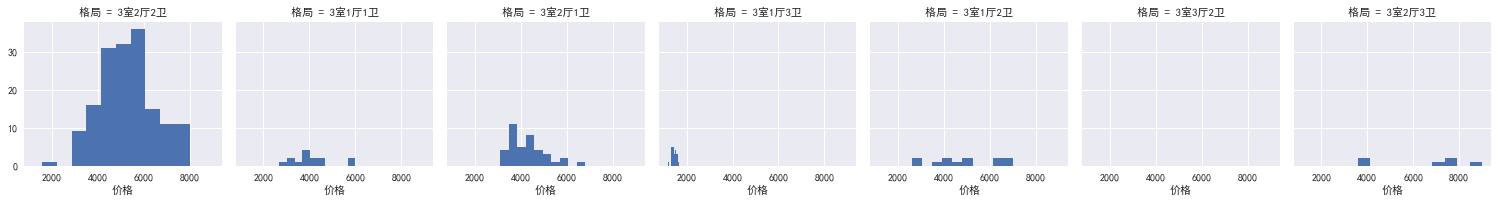

In [27]:
g = sns.FacetGrid(df[df.室 == 3].sort_values('室'), col='格局')
g.map(plt.hist, '价格')
plt.show()

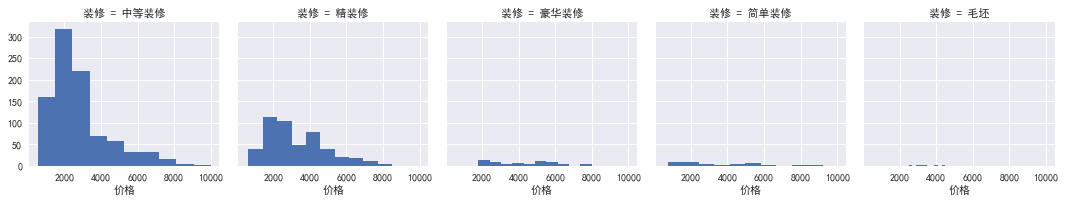

In [28]:
g = sns.FacetGrid(df, col='装修')
g.map(plt.hist, '价格')
plt.show()

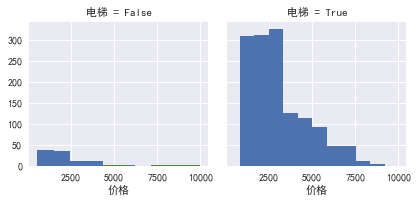

In [29]:
g = sns.FacetGrid(df, col='电梯')
g.map(plt.hist, '价格')
plt.show()

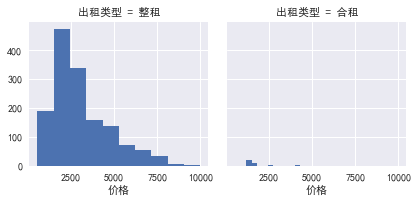

In [30]:
g = sns.FacetGrid(df, col='出租类型')
g.map(plt.hist, '价格')
plt.show()

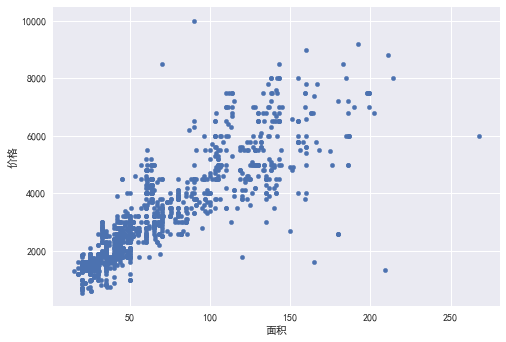

In [31]:
df.plot.scatter(x='面积',y='价格')
plt.show()

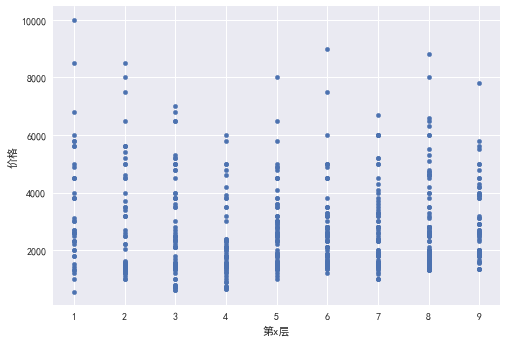

In [32]:
df[df.第x层 < 10].plot.scatter(x='第x层',y='价格')
plt.show()

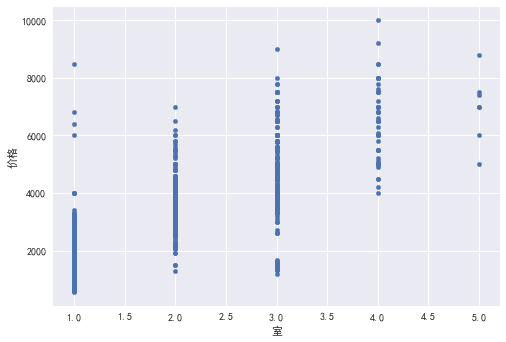

In [33]:
df.plot.scatter(x='室',y='价格')
plt.show()

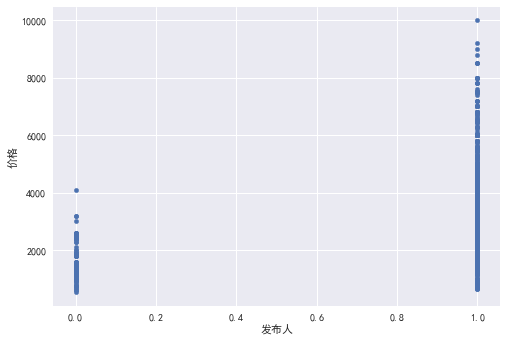

In [34]:
df.plot.scatter(x='发布人',y='价格')
plt.show()

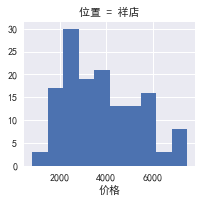

In [35]:
g = sns.FacetGrid(df[(df['位置'].str.contains('店'))], col='位置')
g.map(plt.hist, '价格')
plt.show()

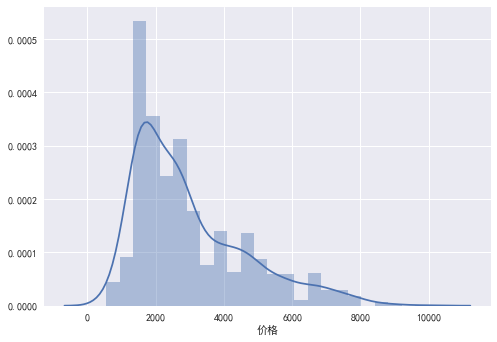

In [36]:
sns.distplot(df.价格);
plt.show()

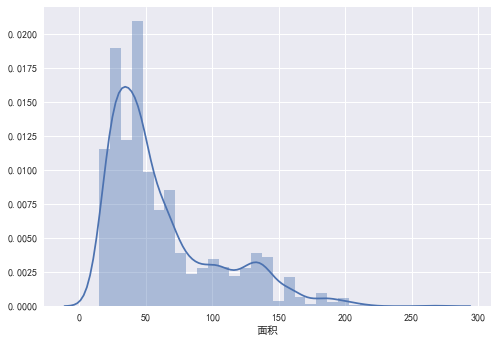

In [37]:
sns.distplot(df.面积);
plt.show()

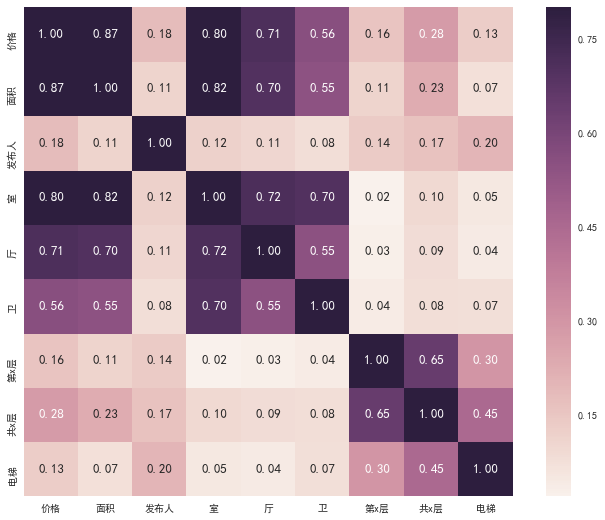

In [38]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True, fmt='.2f');
plt.show()

### 4. 准备开始预测价格

In [39]:
test_df = df.head(1).copy()
# 价格先填个默认价
test_df.loc[0, '标题'] = '我家'
test_df.loc[0, '价格'] = 4500
test_df.loc[0, '出租类型'] = '整租'
test_df.loc[0, '房屋类型'] = '普通住宅'
test_df.loc[0, '格局'] = '4室2厅3卫'
test_df.loc[0, '面积'] = 170
test_df.loc[0, '朝向'] = '朝南北'
test_df.loc[0, '装修'] = '中等装修'
test_df.loc[0, '楼层'] = '第6层/共8层'
test_df.loc[0, '小区'] = '祥店新村'
test_df.loc[0, '位置'] = '祥店'
test_df.loc[0, '发布人'] = 1
test_df.loc[0, '室'] = 4
test_df.loc[0, '厅'] = 2
test_df.loc[0, '卫'] = 3
test_df.loc[0, '第x层'] = 6
test_df.loc[0, '共x层'] = 8
test_df.loc[0, '电梯'] = False
test_df

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
0,我家,4500,整租,普通住宅,4室2厅3卫,170,朝南北,中等装修,第6层/共8层,祥店新村,祥店,1,4,2,3,6,8,False


#### 4.1 取 20 个房来预测租金，用于后续观察（包含自己的房子）

In [40]:
# 把预测🏠 放入数据统一处理成数值型

df = pd.concat([df,test_df], ignore_index=True)
df.tail(20)

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
1470,智能门锁家电齐全拎包入住,1438,整租,公寓,1室1厅1卫,30,朝南北,中等装修,第4层/共14层,UONE天地,高新技术园,1,1,1,1,4,14,True
1471,青友公寓直租免中介费 国际石材新出精装公寓 设计新颖 设施配备齐全 包物业宽带,1800,整租,公寓,1室1厅1卫,25,朝南北,中等装修,第9层/共9层,国际石材中心,市政务中心,1,1,1,1,9,9,True
1472,吕厝，福隆国际，办公装修高层，可注册公司，更多周边房源出租,7000,整租,普通住宅,5室2厅2卫,190,朝南北,中等装修,第22层/共30层,福隆国际,江头北路,1,5,2,2,22,30,True
1473,适合养花养草养动物单身公寓带大露台独门独户软件园二期,4000,整租,普通住宅,1室2厅1卫,50,朝南,精装修,第2层/共8层,上东美地,湖边水库片,1,1,2,1,2,8,True
1474,世茂精装3房软件园10分钟交通配套成熟,6800,整租,普通住宅,3室1厅2卫,135,朝南北,精装修,第25层/共30层,世茂湖滨首府,湖边水库片,1,3,1,2,25,30,True
1475,房东人很好，自住装修，世茂贴心物业，软件园万达，湖边水库,3200,整租,普通住宅,1室1厅1卫,50,朝南北,中等装修,第24层/共38层,世茂湖滨首府B区,湖边水库片,1,1,1,1,24,38,True
1476,靠软件园瑞景会展，建发品质精装拎包入住，房东人很好随时看房！,8000,整租,普通住宅,4室2厅2卫,138,朝南北,豪华装修,第11层/共11层,上东美地,湖边水库片,1,4,2,2,11,11,True
1477,建发品质小区吕岭干道交通方便北万达广场临软件园,4800,整租,普通住宅,3室2厅2卫,133,朝南北,简单装修,第4层/共28层,上东美地,湖边水库片,1,3,2,2,4,28,True
1478,金山BRT附近金山国际精装电梯3房急租哦!业主自住首次出租!,4000,整租,普通住宅,3室2厅2卫,126,朝南北,中等装修,第7层/共18层,金山国际,金山小区,1,3,2,2,7,18,True
1479,房子合适不合适点进来看看就知道绝对不会让您失望！真实房源,3200,整租,普通住宅,1室1厅1卫,65,朝南北,精装修,第25层/共28层,世茂湖滨首府,湖边水库片,1,1,1,1,25,28,True


In [41]:
df.tail(20).价格

1470    1438
1471    1800
1472    7000
1473    4000
1474    6800
1475    3200
1476    8000
1477    4800
1478    4000
1479    3200
1480    2400
1481    3600
1482    1200
1483    2500
1484    2300
1485    1500
1486    1538
1487    1538
1488    2600
1489    4500
Name: 价格, dtype: int64

In [42]:
# 把字符串转成数值因子
le = LabelEncoder()
df.出租类型 = le.fit_transform(df.出租类型)
df.房屋类型 = le.fit_transform(df.房屋类型)
df.格局 = le.fit_transform(df.格局)
df.朝向 = le.fit_transform(df.朝向)
df.装修 = le.fit_transform(df.装修)
df.装修 = le.fit_transform(df.装修)
df.小区 = le.fit_transform(df.小区)
df.位置 = le.fit_transform(df.位置)

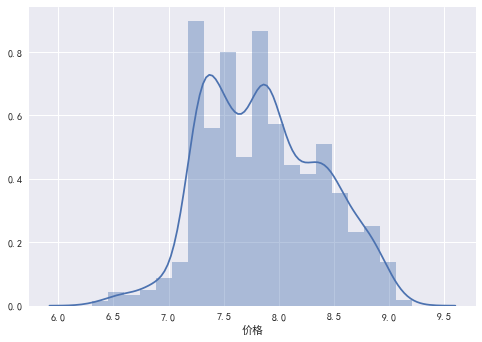

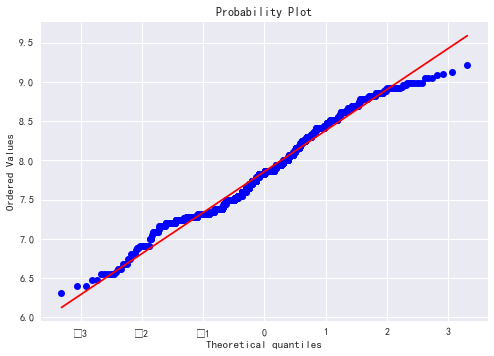

In [43]:
df['价格'] = np.log(df.价格)

sns.distplot(df.价格);
fig = plt.figure()
res = stats.probplot(df.价格, plot=plt)

plt.show()

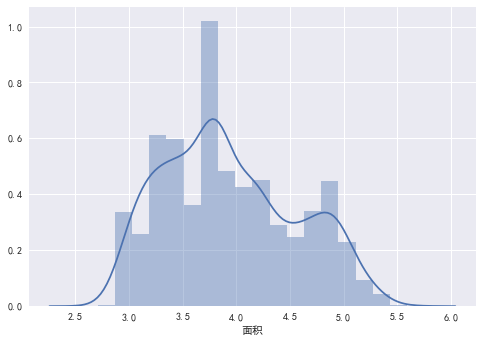

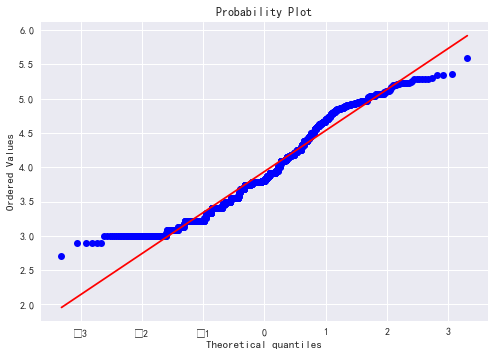

In [44]:

df['面积'] = np.log(df.面积)

sns.distplot(df.面积);
fig = plt.figure()
res = stats.probplot(df.面积, plot=plt)

plt.show()



In [45]:
df.head()

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
0,东方巴黎广场大阳台拎包入住随时看房单身公寓1700,7.438384,1,2,3,3.688879,6,0,第3层/共8层,18,0,1,1,1,1,3,8,True
1,江头吕厝精装高层大3房看中庭2阳台仅4400,8.389360,1,2,17,4.804021,6,0,第27层/共32层,40,27,1,3,2,2,27,32,True
2,台湾街江头公园旁江头小学居家清爽2房2100,7.649693,1,2,9,3.912023,6,0,第8层/共23层,51,13,1,2,1,1,8,23,True
3,sm旁温馨2房独门独户独立厨卫新家具家电干净宽敞舒适,8.006368,1,2,11,4.382027,6,3,第7层/共30层,135,0,1,2,2,1,7,30,True
4,精装修三房拎包入住高档富人社区海景房族7800邮轮城东渡,8.961879,1,2,17,4.912655,6,3,第9层/共30层,65,2,1,3,2,2,9,30,True


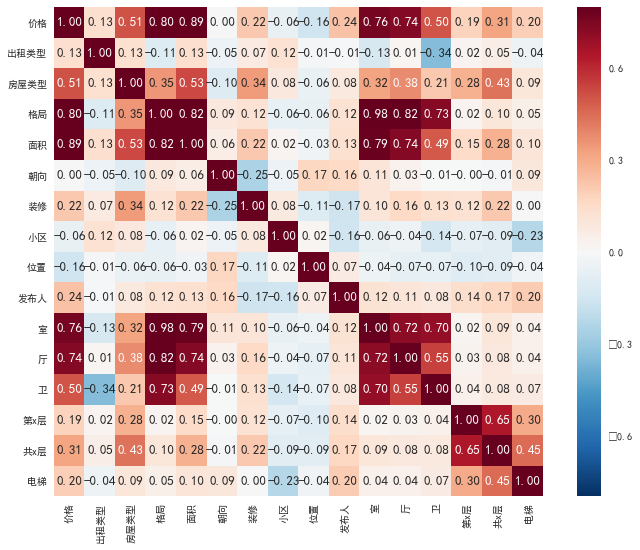

In [46]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True, fmt='.2f');
plt.show()


#### 通过图观察到，价格与面积、格局，室，厅 数据关联性较大

In [47]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
numeric_feats

Index(['价格', '出租类型', '房屋类型', '格局', '面积', '朝向', '装修', '小区', '位置', '发布人', '室',
       '厅', '卫', '第x层', '共x层', '电梯'],
      dtype='object')

In [48]:
# 有些数值特征的分布偏度比较大，可以通过对数变化使其变成正态分布
# skewed_feats = df[numeric_feats].apply(lambda x: stats.skew(x.dropna()))
# print (skewed_feats)
# skewed_feats = skewed_feats[(skewed_feats > 0.75) | (skewed_feats < -0.75)]
# print (skewed_feats)
# skewed_feats = skewed_feats.index

In [49]:
df.head()

,标题,价格,出租类型,房屋类型,格局,面积,朝向,装修,楼层,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
0,东方巴黎广场大阳台拎包入住随时看房单身公寓1700,7.438384,1,2,3,3.688879,6,0,第3层/共8层,18,0,1,1,1,1,3,8,True
1,江头吕厝精装高层大3房看中庭2阳台仅4400,8.389360,1,2,17,4.804021,6,0,第27层/共32层,40,27,1,3,2,2,27,32,True
2,台湾街江头公园旁江头小学居家清爽2房2100,7.649693,1,2,9,3.912023,6,0,第8层/共23层,51,13,1,2,1,1,8,23,True
3,sm旁温馨2房独门独户独立厨卫新家具家电干净宽敞舒适,8.006368,1,2,11,4.382027,6,3,第7层/共30层,135,0,1,2,2,1,7,30,True
4,精装修三房拎包入住高档富人社区海景房族7800邮轮城东渡,8.961879,1,2,17,4.912655,6,3,第9层/共30层,65,2,1,3,2,2,9,30,True


In [50]:
# 归一化
features = df[['价格', '出租类型', '房屋类型', '格局', '面积', '朝向', '装修', '小区', '位置', '发布人', '室', '厅', '卫', '第x层', '共x层', '电梯']]

from sklearn.preprocessing import RobustScaler
N = RobustScaler()
scale_features = N.fit_transform(features)

scale_features

array([[-0.47136074,  0.        ,  0.        , ..., -0.66666667,
        -0.8       ,  0.        ],
       [ 0.63416691,  0.        ,  0.        , ...,  2.        ,
         0.8       ,  0.        ],
       [-0.22570998,  0.        ,  0.        , ..., -0.11111111,
         0.2       ,  0.        ],
       ..., 
       [-0.58778161,  0.        , -1.        , ..., -0.66666667,
        -0.4       ,  0.        ],
       [ 0.02257389,  0.        , -1.        , ..., -0.11111111,
        -0.46666667,  0.        ],
       [ 0.66029203,  0.        ,  0.        , ..., -0.33333333,
        -0.8       , -1.        ]])

### 4.3 分开学习和预测数据

In [51]:
# train_df = features[0:-1]
# test_df = features[-1:]
# train_df.tail()
train_df = features[0:-20]
test_df = features[-20:]
train_df.tail()

,价格,出租类型,房屋类型,格局,面积,朝向,装修,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
1465,8.006368,1,2,2,3.871201,1,0,69,4,1,1,1,0,5,30,True
1466,8.517193,1,2,17,4.867534,4,2,137,4,1,3,2,2,13,28,True
1467,7.279319,1,0,1,3.091042,6,0,80,40,1,1,0,1,6,13,True
1468,7.313220,1,0,3,3.555348,6,0,107,40,1,1,1,1,4,9,True
1469,7.198931,1,0,3,3.135494,6,0,0,11,1,1,1,1,13,14,True


In [52]:
test_df

,价格,出租类型,房屋类型,格局,面积,朝向,装修,小区,位置,发布人,室,厅,卫,第x层,共x层,电梯
1470,7.271009,1,0,3,3.401197,6,0,0,40,1,1,1,1,4,14,True
1471,7.495542,1,0,3,3.218876,6,0,64,20,1,1,1,1,9,9,True
1472,8.853665,1,2,27,5.247024,6,0,149,27,1,5,2,2,22,30,True
1473,8.294050,1,2,5,3.912023,5,3,9,29,1,1,2,1,2,8,True
1474,8.824678,1,2,14,4.905275,6,3,10,29,1,3,1,2,25,30,True
1475,8.070906,1,2,3,3.912023,6,0,12,29,1,1,1,1,24,38,True
1476,8.987197,1,2,22,4.927254,6,4,9,29,1,4,2,2,11,11,True
1477,8.476371,1,2,17,4.890349,6,2,9,29,1,3,2,2,4,28,True
1478,8.294050,1,2,17,4.836282,6,0,182,37,1,3,2,2,7,18,True
1479,8.070906,1,2,3,4.174387,6,3,10,29,1,1,1,1,25,28,True


### 5. 开始机器训练

In [53]:
# 1. 划分训练集和测试集

train_np = train_df.as_matrix()
train_y = train_np[:, 0]
train_X = train_np[:, 1:]


In [54]:
# 2.给训练级模型打分
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X_train,y):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

#### 5.1 XGBRegressor 寻找最优参数，获得推算定价

In [70]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
param_grids = {"n_estimators":[250, 255], 
               "learning_rate":[0.08, 0.09], 
               "max_depth":[6, 7],
               "subsample": [0.6, 0.7],
               "colsample_bytree": [0.5, 0.6]
              }

xgb = XGBRegressor() #定义xgboost回归模型

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grids, cv=5)

grid_search.fit(X=train_X, y=train_y)



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [250, 255], 'learning_rate': [0.08, 0.09], 'max_depth': [6, 7], 'subsample': [0.6, 0.7], 'colsample_bytree': [0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
grid_search.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.08,
 'max_depth': 6,
 'n_estimators': 255,
 'subsample': 0.6}

In [72]:
grid_search.best_score_

0.9028318299380842

In [73]:
xgb = grid_search.best_estimator_
xgb_rmse = rmse_cv(xgb , train_X, train_y)
print ('{:.5f}:+/-{:.5f}'.format( xgb_rmse.mean(), xgb_rmse.std() ))

0.16270:+/-0.01908


In [74]:
# 预测价值

test_np = test_df.as_matrix()
test_X = test_np[:, 1:]

pred_y_log = xgb.predict(test_X)
pred_y = np.expm1(pred_y_log)
pred_y

array([ 1474.21472168,  1807.3614502 ,  7905.27001953,  2410.25195312,
        4870.95703125,  2101.09179688,  7676.56933594,  5600.85839844,
        4150.3828125 ,  3022.00488281,  2338.07910156,  3850.21337891,
        1844.89147949,  2334.42456055,  2188.78442383,  1475.44274902,
        1256.3392334 ,  1370.47998047,  2508.61279297,  5938.43994141], dtype=float32)

#### 5.2 GridSearchCV 寻找最优参数，获得推算定价

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
param_grids = {"n_estimators":[230, 240], 
               "learning_rate":[0.09, 0.1], 
               "max_depth":[4, 5],
               "min_samples_split":[12, 15 ,18],
               "min_samples_leaf":[3, 4],
              }

gbr = GradientBoostingRegressor() #定义xgboost回归模型

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grids, cv=5)

grid_search.fit(X=train_X, y=train_y)


# n_estimators=300, 
# learning_rate=0.1,
# max_depth=3,
# min_samples_split=20,
# min_samples_leaf=5

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [230, 240], 'learning_rate': [0.09, 0.1], 'max_depth': [4, 5], 'min_samples_split': [12, 15, 18], 'min_samples_leaf': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 18,
 'n_estimators': 230}

In [61]:
grid_search.best_score_

0.90259790665218165

In [62]:
gbr = grid_search.best_estimator_
gbr_rmse = rmse_cv(gbr , train_X, train_y)
print ('{:.5f}:+/-{:.5f}'.format( gbr_rmse.mean(), gbr_rmse.std() ))

0.16264:+/-0.01592


In [63]:
# 预测价值

test_np = test_df.as_matrix()
test_X = test_np[:, 1:]

pred_y_log = gbr.predict(test_X)
pred_y = np.expm1(pred_y_log)
pred_y

array([ 1500.87449737,  1829.97525622,  8499.40948954,  2546.36609894,
        4683.74106551,  1556.29243528,  7964.72534718,  5838.04880019,
        4230.31346296,  3052.65770038,  2537.61571311,  4050.6362414 ,
        2132.35447373,  2542.88443885,  2112.1923162 ,  1478.37065692,
        1268.61388046,  1352.01292131,  2545.16847419,  5263.17464002])

#### 5.3 RandomForestRegressor 寻找最优参数，获得推算定价

In [64]:
from sklearn.ensemble import RandomForestRegressor
param_grids = {"n_estimators":[450, 500, 550] }
rfr = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grids, cv=5)
grid_search.fit(X=train_X, y=train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [450, 500, 550]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [65]:
grid_search.best_params_

{'n_estimators': 450}

In [66]:
grid_search.best_score_

0.89357575171039649

In [67]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=450, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [68]:
rfr = grid_search.best_estimator_
rfr_rmse = rmse_cv(rfr , train_X, train_y)
print ('{:.5f}:+/-{:.5f}'.format( rfr_rmse.mean(), rfr_rmse.std() ))

0.17013:+/-0.02068


In [69]:

test_np = test_df.as_matrix()
test_X = test_np[:, 1:]

pred_y_log = rfr.predict(test_X)
pred_y = np.expm1(pred_y_log)
pred_y

array([ 1499.01704096,  1851.06454843,  6939.29324748,  2536.22970407,
        4694.83503422,  1277.61486013,  7302.40031477,  5963.71756933,
        4675.14805272,  3071.354491  ,  2513.18344731,  4010.47478272,
        1924.99458111,  2573.30353359,  2143.0992764 ,  1469.01737854,
        1384.98448167,  1354.93386677,  2600.3798349 ,  6114.15526746])